# Translating with Attention

This notebook provides you with a complete code example that demonstrates how to implement a sequence-to-sequence (seq2seq) model for machine translation using recurrent neural networks and the dot-product attention mechanism.

## Preparing the Bilingual Dataset

### Tokenizing the Sentences

Implement a function to tokenize a sentence ...

In [1]:
import spacy

tokenizers = {"eng": spacy.blank("en"), "spa": spacy.blank("es")}

def tokenize(text, lang="eng"):
    """Tokenize text."""
    tokens = tokenizers[lang](text)
    return tokens

In [2]:
print([token.text for token in tokenize("This is a simple example!")]) 

['This', 'is', 'a', 'simple', 'example', '!']


... then update this function to handle contractions ...

In [3]:
import contractions, spacy

tokenizers = {"eng": spacy.blank("en"), "spa": spacy.blank("es")}

def tokenize(text, lang="eng"):
    """Tokenize text."""
    text = contractions.fix(text) if lang == "eng" else text
    tokens = tokenizers[lang](text)
    return tokens

In [4]:
print([token.text for token in tokenize("This isn't the same example!")])

['This', 'is', 'not', 'the', 'same', 'example', '!']


... then update this function to remove irrelevant punctuation and non-alphabetical characters ...

In [5]:
import contractions, re, spacy, unicodedata

tokenizers = {"eng": spacy.blank("en"), "spa": spacy.blank("es")}

regular_expression = r"^[a-zA-Z0-9áéíóúüñÁÉÍÓÚÜÑ.,!?¡¿/:()]+$"
pattern = re.compile(unicodedata.normalize("NFC", regular_expression))

def tokenize(text, lang="eng"):
    """Tokenize text."""
    swaps = {"’": "'", "‘": "'", "“": '"', "”": '"', "´": "'", "´´": '"'}
    for old, new in swaps.items():
        text = text.replace(old, new)
    text = contractions.fix(text) if lang == "eng" else text
    tokens = tokenizers[lang](text)
    return [token.text for token in tokens if pattern.match(token.text)]

In [6]:
print([token for token in tokenize("Double-check your code!")])

['Double', 'check', 'your', 'code', '!']


### Implementing a Corpus Iterator

Implement a function to read and tokenize sentences by iterating through a corpus file ...

In [7]:
def corpus_iterator(filename, lang, lang_position):
    """Read and tokenize texts by iterating through a corpus file."""
    with open(filename, "r", encoding="utf-8") as file:
        for line in file:
            sentences = line.strip().split("\t")
            sentence = unicodedata.normalize("NFC", sentences[lang_position])
            yield tokenize(sentence, lang)

### Building a Vocabulary

Implement a class to represent a vocabulary ...

In [8]:
class Vocab:
    """Vocabulary as callable dictionary."""
    
    def __init__(self, vocab_dict, unk_token="<unk>"):
        """Initialize vocabulary"""
        self.vocab_dict, self.unk_token = vocab_dict, unk_token
        self.default_index = vocab_dict.get(unk_token, -1)
        self.index_to_token = {idx: token for token, idx in vocab_dict.items()}
        
    def __call__(self, token_or_tokens):
        """Return the index(es) for given token or list of tokens."""
        if not isinstance(token_or_tokens, list):
            return self.vocab_dict.get(token_or_tokens, self.default_index)
        else:
            return [self.vocab_dict.get(token, self.default_index) 
                    for token in token_or_tokens]
    
    def set_default_index(self, index):
        """Set default index for unknown tokens."""
        self.default_index = index

    def lookup_token(self, index_or_indices):
        """Retrieve token corresponding to given index or list of indices."""
        if not isinstance(index_or_indices, list):
            return self.index_to_token.get(int(index_or_indices), self.unk_token)
        else:
            return [self.index_to_token.get(int(index), self.unk_token) 
                    for index in index_or_indices]

    def get_itos(self):
        """Return a list of tokens ordered by their index."""
        itos = [None] * len(self.index_to_token)
        for index, token in self.index_to_token.items():
            itos[index] = token
        return itos
        
    def __iter__(self):
        """Iterate over the tokens in the vocabulary."""
        return iter(self.vocab_dict)

    def __len__(self):
        """Return the number of tokens in the vocabulary."""
        return len(self.vocab_dict)
    
    def __contains__(self, token):
        """Check if a token is in the vocabulary."""
        return token in self.vocab_dict

... which you can use as shown ...

In [9]:
vocab_dict = {"hello": 0, "world": 1, "<unk>": 2}
vocab = Vocab(vocab_dict)

In [10]:
vocab("hello")

0

In [11]:
vocab("unknown")

2

In [12]:
vocab.lookup_token(1)

'world'

In [13]:
vocab.lookup_token(5)

'<unk>'

... implement a function to build vocabulary from an iterator ...

In [14]:
from collections import Counter

def build_vocab_from_iterator(iterator, specials=None, min_freq=1):
    """Build vocabulary from an iterator over tokenized sentences."""
    token_freq = Counter(token for tokens in iterator for token in tokens)
    vocab, index = {}, 0
    if specials: 
        for token in specials: 
            vocab[token] = index
            index += 1
    for token, freq in token_freq.items():
        if freq >= min_freq:
            vocab[token] = index
            index += 1
    return vocab

... which you can then use on a list of tokenized sentences ...

In [15]:
tokenized_sentences = [["this", "is", "an", "example"], 
                       ["another", "example", "sentence"],
                       ["this", "is", "a", "test"]]
vocab_dict = build_vocab_from_iterator(
    tokenized_sentences, specials=["<unk>", "<pad>"], min_freq=1, 
)

In [16]:
print(vocab_dict)

{'<unk>': 0, '<pad>': 1, 'this': 2, 'is': 3, 'an': 4, 'example': 5, 'another': 6, 'sentence': 7, 'a': 8, 'test': 9}


... implement a function to build a vocabulary from a corpus file ...

In [17]:
def build_vocab(filename, lang, lang_position, specials=["<unk>"], min_freq=5):
    """Build vocabulary."""
    vocab_dict = build_vocab_from_iterator(
        corpus_iterator(filename, lang, lang_position), specials, min_freq,
    )
    vocab = Vocab(vocab_dict, unk_token=specials[0]) 
    vocab.set_default_index(vocab(specials[0]))
    return vocab

... and use this function to create the vocabularies for the input and output vocabularies.

In [18]:
in_lang, out_lang, filename = "eng", "spa", "eng-spa.txt"
specials = ["<pad>", "<sos>", "<eos>", "<unk>"]

in_vocab = build_vocab(filename, in_lang, lang_position=0, specials=specials)
out_vocab = build_vocab(filename, out_lang, lang_position=1, specials=specials)

## Preprocessing the Data

Implement a function to check if all words in a sentence are present in a vocabulary ...

In [19]:
def all_words_in_vocab(sentence, vocab):
    """Check whether all words in a sentence are present in a vocabulary"""
    return all(word in vocab for word in sentence)

... a function to pad a sequence of tokens ...

In [20]:
def pad(tokens, max_length=10):
    """Pad sequence of tokens."""
    padding_length = max_length - len(tokens)
    return ["<sos>"] + tokens + ["<eos>"] + ["<pad>"] * padding_length

... a function to process the language corpus ...

In [21]:
import numpy as np

def process(filename, in_lang, out_lang, in_vocab, out_vocab, max_length=10):
    """Process language corpus."""
    in_sequences, out_sequences = [], []
    with open(filename, "r", encoding="utf-8") as file:
        for line in file:
            sentences = line.strip().split("\t")
            in_tokens = tokenize(unicodedata.normalize("NFC", sentences[0]),
                                 in_lang)
            out_tokens = tokenize(unicodedata.normalize("NFC", sentences[1]), 
                                  out_lang)
        
            if (all_words_in_vocab(in_tokens, in_vocab)
                and len(in_tokens) <= max_length
                and all_words_in_vocab(out_tokens, out_vocab)
                and len(out_tokens) <= max_length):
                
                padded_in_tokens = pad(in_tokens)
                in_sequence = in_vocab(padded_in_tokens)
                in_sequences.append(in_sequence)
                
                padded_out_tokens = pad(out_tokens)
                out_sequence = out_vocab(padded_out_tokens)
                out_sequences.append(out_sequence)
    return np.array(in_sequences), np.array(out_sequences)

... and build the datasets and data loaders.

In [22]:
import deeptrack as dt
import torch
from torch.utils.data import DataLoader

in_sequences, out_sequences = \
    process(filename, in_lang, out_lang, in_vocab, out_vocab)

sources = dt.sources.Source(inputs=in_sequences, targets=out_sequences)
train_sources, test_sources = dt.sources.random_split(sources, [0.85, 0.15])

inputs_pip = dt.Value(sources.inputs) >> dt.pytorch.ToTensor(dtype=torch.int)
outputs_pip = dt.Value(sources.targets) >> dt.pytorch.ToTensor(dtype=torch.int)

train_dataset = \
    dt.pytorch.Dataset(inputs_pip & outputs_pip, inputs=train_sources)
test_dataset = \
    dt.pytorch.Dataset(inputs_pip & outputs_pip, inputs=test_sources)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

## Implementing and Training the Sequence-to-Sequence Architecture

Implement the encoder ...

In [23]:
import deeplay as dl

class Seq2SeqEncoder(dl.DeeplayModule):
    """Sequence-to-sequence encoder."""

    def __init__(self, vocab_size, in_feats=300, hidden_feats=128,
                 hidden_layers=1, dropout=0.0):
        """Initialize sequence-to-sequence encoder."""
        super().__init__()
        self.hidden_feats, self.hidden_layers = hidden_feats, hidden_layers
        
        self.embedding = dl.Layer(torch.nn.Embedding, vocab_size, in_feats)
        self.rnn = dl.Layer(torch.nn.GRU, input_size=in_feats, 
                            hidden_size=hidden_feats, num_layers=hidden_layers, 
                            dropout=(0 if hidden_layers == 1 else dropout),
                            bidirectional=True, batch_first=True)

    def forward(self, in_sequences, contexts=None):
        """Perform forward pass."""
        in_embeddings = self.embedding(in_sequences)
        encoded_sequences, contexts = self.rnn(in_embeddings, contexts)
        encoded_sequences = (encoded_sequences[:, :, :self.hidden_feats]
                             + encoded_sequences[:, :, self.hidden_feats:])
        contexts = contexts[:self.hidden_layers]
        return encoded_sequences, contexts

... implement a class to perform dot-product attention ...

In [24]:
class DotProductAttention(dl.DeeplayModule):
    """Dot-product attention."""
    
    def __init__(self):
        """Initialize dot-product attention."""
        super().__init__()

    def forward(self, queries, keys, values):
        """Calculate dot-product attention."""
        attn_scores = (torch.matmul(queries, keys.transpose(-2, -1))
                       / (keys.size(-1) ** 0.5))
        attn_matrix = torch.nn.functional.softmax(attn_scores, dim=-1)
        attn_output = torch.matmul(attn_matrix, values)
        return attn_output, attn_matrix

... implement the decoder ...

In [25]:
class Seq2SeqDecoder(dl.DeeplayModule):
    """Sequence-to-sequence decoder with dot-product attention."""

    def __init__(self, vocab_size, in_feats=300, hidden_feats=128, 
                 hidden_layers=1, dropout=0.0):
        """Initialize sequence-to-sequence decoder."""
        super().__init__()

        self.embedding = dl.Layer(torch.nn.Embedding, vocab_size, in_feats)
        self.rnn = dl.Layer(torch.nn.GRU, input_size=in_feats,
                            hidden_size=hidden_feats, num_layers=hidden_layers,
                            bidirectional=False, batch_first=True,
                            dropout=(0 if hidden_layers == 1 else dropout))
        self.dense = dl.Layer(torch.nn.Linear, hidden_feats, vocab_size)
        self.softmax = dl.Layer(torch.nn.Softmax, dim=-1)
        self.attn = DotProductAttention()

    def forward(self, decoder_in_values, contexts, encoded_sequences):
        """Perform forward pass."""
        out_embeddings = self.embedding(decoder_in_values)
        decoder_outputs, contexts = self.rnn(out_embeddings, contexts)
        attn_contexts, attn_weights = self.attn(
            queries=decoder_outputs, 
            keys=encoded_sequences, 
            values=encoded_sequences,
        )
        decoder_outputs = decoder_outputs + attn_contexts
        decoder_outputs = self.dense(decoder_outputs)
        decoder_outputs = self.softmax(decoder_outputs)
        return decoder_outputs, contexts, attn_weights

... implement the full seq2seq model combining the encoder and decoder ...

In [26]:
class Seq2SeqModel(dl.DeeplayModule):
    """Sequence-to-sequence model with attention."""

    def __init__(self, in_vocab_size=None, out_vocab_size=None, embed_dim=300, 
                 hidden_feats=128, hidden_layers=1, dropout=0.0, 
                 teacher_prob=1.0):
        """Initialize the sequence-to-sequence model."""
        super().__init__()
        self.in_vocab_size, self.out_vocab_size = in_vocab_size, out_vocab_size
        
        self.encoder = Seq2SeqEncoder(in_vocab_size, embed_dim, hidden_feats, 
                                      hidden_layers, dropout)
        self.decoder = Seq2SeqDecoder(out_vocab_size, embed_dim, hidden_feats, 
                                      hidden_layers, dropout)
        self.teacher_prob = teacher_prob

    def forward(self, batch):
        """Perform forward pass."""
        in_sequences, out_sequences = batch
        num_sequences, sequence_length = in_sequences.size()
        device = next(self.encoder.parameters()).device
        
        encoder_outputs, contexts = self.encoder(in_sequences)
        
        decoder_outputs_vec = torch.zeros(num_sequences, sequence_length,
                                          self.out_vocab_size).to(device)
        decoder_in_values = torch.full(size=(num_sequences, 1), 
                                       fill_value=1, device=device)  # <sos>
        for t in range(sequence_length):
            decoder_outputs, contexts, _ = self.decoder(
                decoder_in_values, contexts, encoder_outputs,
            )
            decoder_outputs_vec[:, t, :] = decoder_outputs.squeeze(1)

            if (np.random.rand() < self.teacher_prob 
                and t < sequence_length - 1):  # Teacher forcing.
                decoder_in_values = \
                    out_sequences[:, t + 1].unsqueeze(-1).to(device)
            else:  # Model prediction.
                _, top_decoder_outputs = decoder_outputs.topk(1)
                decoder_in_values = \
                    top_decoder_outputs.squeeze(-1).detach().to(device)
        
        return decoder_outputs_vec
    
    def evaluate(self, in_sequences):
        """Evaluate model."""
        num_sequences, sequence_length = in_sequences.size()
        device = next(self.encoder.parameters()).device

        with torch.no_grad():
            encoder_outputs, contexts = self.encoder(in_sequences)
        
        pred_sequences = torch.zeros(num_sequences, sequence_length).to(device)
        decoder_in_values = torch.full(size=(num_sequences, 1), 
                                       fill_value=1, device=device)  # <sos>
        attn_matrices = torch.zeros(
            num_sequences, sequence_length, sequence_length
        ).to(device)
        for t in range(sequence_length):
            with torch.no_grad():
                decoder_outputs, contexts, attn_weights = self.decoder(
                    decoder_in_values, contexts, encoder_outputs,
                )
                attn_matrices[:, t, :] = attn_weights.squeeze(1)
            _, top_decoder_outputs = decoder_outputs.topk(1)
            pred_sequences[:, t] = top_decoder_outputs.squeeze()

            decoder_in_values = top_decoder_outputs.squeeze(-1).detach()
            
        return pred_sequences, attn_matrices

... define the loss function ...

In [27]:
def maskedNLL(decoder_outputs, out_sequences, padding=0):
    """Calculate the masked negative log-likelihood (NLL) loss."""
    flat_pred_sequences = decoder_outputs.view(-1, decoder_outputs.shape[-1])
    flat_target_sequences = out_sequences.view(-1, 1)
    pred_probs = torch.gather(flat_pred_sequences, 1, flat_target_sequences)

    nll = - torch.log(pred_probs)

    mask = out_sequences != padding
    masked_nll = nll.masked_select(mask.view(-1, 1))
    
    return masked_nll.mean()  # Loss.

... and implement the sequence-to-sequence application.

In [28]:
class Seq2Seq(dl.Application):
    """Application for the sequence-to-sequence model."""

    def __init__(self, in_vocab, out_vocab, teacher_prob=1.0):
        """Initialize the application."""
        super().__init__(loss=maskedNLL, optimizer=dl.Adam(lr=1e-3))
        self.model = Seq2SeqModel(in_vocab_size=len(in_vocab),
                                  out_vocab_size=len(out_vocab), 
                                  teacher_prob=teacher_prob)

    def train_preprocess(self, batch):
        """Adjust the target sequence by shifting it one position backward."""
        in_sequences, out_sequences = batch
        shifted_out_sequences = \
            torch.cat((out_sequences[:, 1:], out_sequences[:, -1:]), dim=1)
        return (in_sequences, out_sequences), shifted_out_sequences
    
    def forward(self, batch):
        """Perform forward pass."""
        return self.model(batch)

## Loading Pretrained Embeddings

Download the GloVe embeddings ...

In [29]:
import os
from torchvision.datasets.utils import download_url, extract_archive

glove_folder = os.path.join(".", ".glove_cache")
zip_filepath = os.path.join(glove_folder, "glove.42B.300d.zip")
if not os.path.exists(glove_folder):
    os.makedirs(glove_folder, exist_ok=True)
    url = "https://nlp.stanford.edu/data/glove.42B.300d.zip"
    download_url(url, glove_folder)
    extract_archive(zip_filepath, glove_folder)
    os.remove(zip_filepath)

... implement a function to load the GloVe embeddings ...

In [30]:
def load_glove_embeddings(glove_file):
    """Load GloVe embeddings."""
    glove_embeddings = {}
    with open(glove_file, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            glove_embeddings[word] = np.round(
                np.asarray(values[1:], dtype='float32'), decimals=6,
            )
    return glove_embeddings

... implement a function to get GloVe embeddings for a vocabulary ...

In [31]:
def get_glove_embeddings(vocab, glove_embeddings, embed_dim):
    """Get GloVe embeddings for a vocabulary."""
    embeddings = torch.zeros((len(vocab), embed_dim), dtype=torch.float32)
    for i, token in enumerate(vocab):
        embedding = glove_embeddings.get(token)
        if embedding is None:
            embedding = glove_embeddings.get(token.lower())
        if embedding is not None:
            embeddings[i] = torch.tensor(embedding, dtype=torch.float32)
    return embeddings

... load the pretrained GloVe embeddings ...

In [32]:
glove_file = os.path.join(glove_folder, "glove.42B.300d.txt")
glove_embeddings, glove_dim = load_glove_embeddings(glove_file), 300

embeddings_in = get_glove_embeddings(in_vocab.get_itos(), 
                                     glove_embeddings, glove_dim)
embeddings_out = get_glove_embeddings(out_vocab.get_itos(), 
                                      glove_embeddings, glove_dim)

num_specials = len(specials)
embeddings_in[1:num_specials] = torch.rand(num_specials - 1, glove_dim) * 0.01
embeddings_out[1:num_specials] = torch.rand(num_specials - 1, glove_dim) * 0.01

## Training the Sequence-to-Sequence Application

Create the seq2seq model ...

In [33]:
seq2seq = Seq2Seq(in_vocab=in_vocab, out_vocab=out_vocab, teacher_prob=0.85)
seq2seq = seq2seq.create()

seq2seq.model.encoder.embedding.weight.data = embeddings_in
seq2seq.model.encoder.embedding.weight.requires_grad = False
seq2seq.model.decoder.embedding.weight.data = embeddings_out
seq2seq.model.decoder.embedding.weight.requires_grad = False


... and train the model.

In [34]:
trainer = dl.Trainer(max_epochs=25, accelerator="auto")
trainer.fit(seq2seq, train_loader)

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ train_metrics │ MetricCollection │      0 │ train │
│ 1 │ val_metrics   │ MetricCollection │      0 │ train │
│ 2 │ test_metrics  │ MetricCollection │      0 │ train │
│ 3 │ model         │ Seq2SeqModel     │  6.3 M │ train │
│ 4 │ optimizer     │ Adam             │      0 │ train │
└───┴───────────────┴──────────────────┴────────┴───────┘

Trainable params: 1.7 M                                                                                            
Non-trainable params: 4.6 M                                                                                        
Total params: 6.3 M                                                                                                
Total estimated model params size (MB): 25                                                                         
Modules in train mode: 14                                                                                          
Modules in eval mode: 0

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


## Testing the Model Perfomance

Implement a function to convert numerical sequences into their corresponding text ...

In [35]:
def unprocess(sequences, vocab, specials):
    """Convert numeric sequences to sentences."""
    sentences = []
    for sequence in sequences:
        idxs = sequence[sequence > len(specials) - 1]
        words = [vocab.lookup_token(idx) for idx in idxs]
        sentences.append(" ".join(words))
    return sentences

... a function to translate user-defined sentences ...

In [36]:
def translate(in_sentence, model, in_lang, in_vocab, out_vocab, specials):
    """Translate a sentence."""
    in_sentence = unicodedata.normalize("NFC", in_sentence)
    in_tokens = pad(tokenize(in_sentence, in_lang))
    in_sequence = (torch.tensor(in_vocab(in_tokens), dtype=torch.int)
                   .unsqueeze(0).to(next(model.parameters()).device))
    pred_sequence, attn_matrix = model.evaluate(in_sequence)
    pred_sentence = unprocess(pred_sequence, out_vocab, specials)
    print(f"Predicted Translation: {pred_sentence[0]}\n")
    pred_tokens = [out_vocab.lookup_token(idx) for idx in pred_sequence[0]]
    return in_tokens, pred_tokens, attn_matrix.squeeze()

... try to translate a simple sentence ...

In [45]:
in_sentence = "I bought a book."
translate(in_sentence, seq2seq.model, in_lang, in_vocab, out_vocab, specials);

Predicted Translation: Compré un libro .



... another simple sentence ...

In [46]:
in_sentence = "This book is very interesting."
translate(in_sentence, seq2seq.model, in_lang, in_vocab, out_vocab, specials);

Predicted Translation: Este libro es muy interesante .



... a more complex one ...

In [47]:
in_sentence = "The book that I bought is very interesting."
in_tokens, pred_tokens, attn_matrix = translate(
    in_sentence, seq2seq.model, in_lang, in_vocab, out_vocab, specials,
)

Predicted Translation: El libro que compré es muy interesante .



... implement the fuction to plot the attention ...

In [71]:
from matplotlib import pyplot as plt 
from matplotlib.ticker import FixedLocator

def plot_attention(in_tokens, pred_tokens, attn_matrix, specials):
    """Plot attention."""
    in_tokens = [token for token in in_tokens if token not in specials]
    pred_tokens = [token for token in pred_tokens if token not in specials]
    
    fig, ax = plt.subplots()
    cax = ax.matshow(attn_matrix[:len(pred_tokens), 1:len(in_tokens) + 1], 
                     cmap="bone")
    fig.colorbar(cax)
    ax.xaxis.set_major_locator(FixedLocator(range(len(in_tokens))))
    ax.yaxis.set_major_locator(FixedLocator(range(len(pred_tokens))))
    ax.set_xticklabels(in_tokens, rotation=90)
    ax.set_yticklabels(pred_tokens)
    plt.show()

... use it to plot the attention heatmap ...

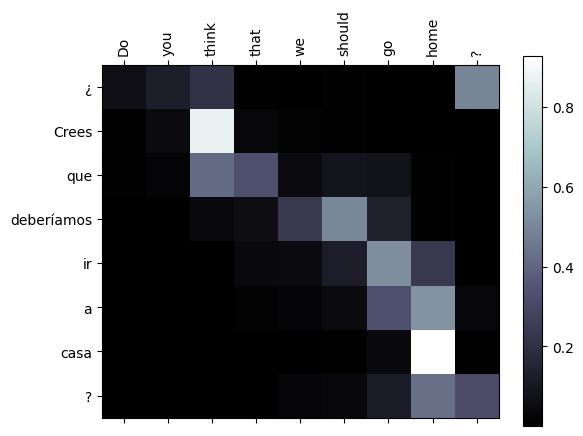

In [72]:
plot_attention(in_tokens, pred_tokens, attn_matrix, specials)

... now challenge the model with an interrogative sentence ...

Predicted Translation: ¿ Crees que deberíamos ir a casa ?



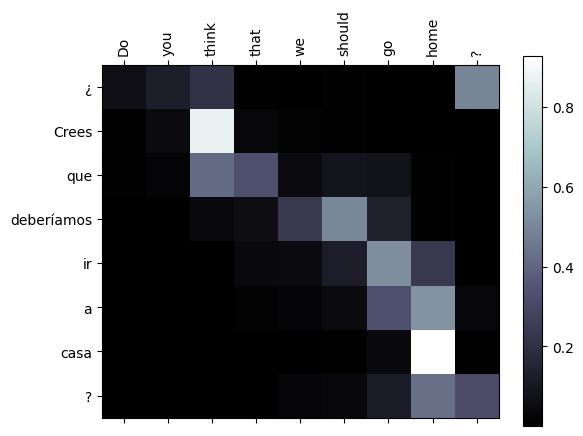

In [74]:
in_sentence = "Do you think that we should go home?"
in_tokens, pred_tokens, attn_matrix = translate(
    in_sentence, seq2seq.model, in_lang, in_vocab, out_vocab, specials,
)
plot_attention(in_tokens, pred_tokens, attn_matrix, specials)

## Evaluating the Model with the BLEU Score

In [43]:
from torchmetrics.text import BLEUScore

bleu_score = BLEUScore()

device = next(seq2seq.model.parameters()).device
for batch_index, (in_sequences, out_sequences) in enumerate(test_loader):
    in_sentences = unprocess(in_sequences.to(device), in_vocab, specials)
    pred_sequences, _ = seq2seq.model.evaluate(in_sequences.to(device))
    pred_sentences= unprocess(pred_sequences, out_vocab, specials)
    out_sentences = unprocess(out_sequences.to(device), out_vocab, specials)
    
    bleu_score.update(pred_sentences, [[s] for s in out_sentences])

    print(f"Input sentence: {in_sentences[0]}\n" 
          + f"Predicted Translation: {pred_sentences[0]}\n"
          + f"Actual Translation: {out_sentences[0]}\n")
final_bleu = bleu_score.compute()
print(f"Validation BLEU Score: {final_bleu:.3f}")

Input sentence: He came to my house .
Predicted Translation: Él vino a mi casa .
Actual Translation: Ha venido a mi casa .

Input sentence: I know what you did in Boston .
Predicted Translation: Sé lo que hicisteis en Boston .
Actual Translation: Sé lo que hicieron ustedes en Boston .

Input sentence: You make it look easy .
Predicted Translation: Tú haces fácil de forma fácil .
Actual Translation: Lo haces parecer fácil .

Input sentence: This time it is different .
Predicted Translation: Esta vez es es diferente .
Actual Translation: En esta ocasión es diferente .

Input sentence: I did not want to disturb you .
Predicted Translation: No quise molestarte . .
Actual Translation: No quise molestarte .

Input sentence: Try to explain this .
Predicted Translation: Trata de explicarlo esto .
Actual Translation: Intenta explicarme esto .

Input sentence: Could you pass me the salt , please ?
Predicted Translation: ¿ Me podrías pasarme la sal , por favor ?
Actual Translation: ¿ Me podrías p